### Submission guidelines

1. Fill in your name in the notebook in the top cell.
2. Fill in the gaps in the code where indicated. <br> Make sure that you:<br> - fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" <br> - **do not leave any `raise NotImplementedErrors`** in the code
3. Do **NOT change the variable names**, however, you can add comments in the code.
4. Do **NOT remove any of the cells** of the notebook!
5. Discussion is allowed, but every student needs to hand a personal version of the lab. Plagiarism will be sanctioned!   
6. Before submitting, restart your kernel & **make sure that every cell runs**.<br>Code that doesn't run will not be scored.<br>The notebooks with all source code, and optional extra files need to be handed in using Ufora.<br> Make sure all your notebooks are already executed when you upload them (i.e. there should be output after the cells). 
7. **Zip** your lab assignment folder and name the archive: `Surname_Name.zip` <br> Keep the same folder structure as the provided lab assignment!<br><span style='color: red'>Do not rename any of the notebooks or files</span>!<br>



In [ ]:
NAME = ""


Final tip: make sure you have answered every question and filled in all the required code by running through the notebook and searching for *YOUR ANSWER HERE* and *YOUR CODE HERE*!

Good luck!

---

# Part 3 - Mortality Clustering and Classification

## Objective and approach

The next section focuses on building mortality prediction models/classifiers using some algorithms seen in the theory lessons. We will use the following algorithms: 
- Clustering
- Logistic regression
- Decision Trees and Random Forests

The first step is to import essential python libraries and MIMIC-III data. As start point we use the features created in the 'Data_preparation' notebook. So make sure you already went through this notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import warnings
np.random.seed(12)

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

We can load the cleaned dataset that was created in the **Data_preparation** notebook.

In [ ]:
### Path to your cleaned dataset file
path_to_data_file = 'cleaned_dataset.parquet'

# Load data as a pandas DataFrame using the ICU stay ID as the DataFrame index, for facilitating data manipulation.
data = pd.read_parquet(path_to_data_file)

Let's look at our features:

In [ ]:
data.head()

In [ ]:
data.columns

# Data processing

## Data splitting

In order to assess the performance of the models, data can be divided into:

* Training set: used to train/build the learning algorithm.
* Validation (or development) set: use to tune parameters, select features, and make other decisions regarding the learning algorithm. 
* Test set: used to evaluate the performance of the algorithm, but not to make any decisions regarding what learning algorithm or parameters to use.

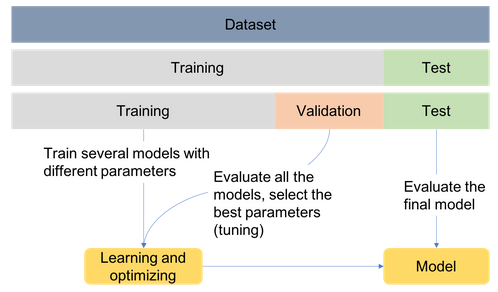

For simplicity, data will be divided into two sets, one for training and another for testing. Later, when performing cross validation, the training set will be divided into two sets, for training and validation.


We will use the 'train_test_split' function from sklearn library, which randomly assigns observations to each set. The size of the sets can be controlled using the 'test_size' parameter, which defines the size of the test set and which in this case will be set to 20%. When using the 'train_test_split' function, it is important to set the 'random_state' parameter so that later the same results can be reproduced.


In [ ]:
from sklearn.model_selection import train_test_split

# set the % of observations in the test set
test_size = 0.2

# Divide the data intro training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='mortality_icu'), data[['mortality_icu']], test_size = test_size, random_state = 10)

## Normalization

Normalization, or scaling, is used to ensure that all features lie between a given minimum and maximum value, often between zero and one. The maximum and mininum values of each feature should be determined during the training phase and the same values should be applied during the test phase. Most machine learning models  prefer normalized features, so it's a good practice to always normalize your features.

The next example is used to normalize the features extracted from the time series according to

$x_{norm} = \frac{x-min(x)}{max(x) - min(x)}$


The next example uses the 'preprocessing' package from 'sklearn':


In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# The same instance of the transformer can be applied to new test data unseen during the fit call:
# the same scaling and shifting operations will be applied to be consistent with the transformation performed on the train data.
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

Now we have a normalized dataset:

In [ ]:
X_train.head()

## Balancing the dataset

Let's check the respective sizes of our train and test set:

In [ ]:
def print_size(y_train, y_test):
    print(str(len(y_train[y_train['mortality_icu']==1])) + '(' + str(round(len(y_train[y_train['mortality_icu']==1])/len(y_train)*100,1)) + '%)' + ' non-survivors in training set')
    print(str(len(y_train[y_train['mortality_icu']==0])) + '(' + str(round(len(y_train[y_train['mortality_icu']==0])/len(y_train)*100,1)) + '%)' + ' survivors in training set')
    print(str(len(y_test[y_test['mortality_icu']==1])) + '(' + str(round(len(y_test[y_test['mortality_icu']==1])/len(y_test)*100,1)) + '%)' + ' non-survivors in test set')
    print(str(len(y_test[y_test['mortality_icu']==0])) + '(' + str(round(len(y_test[y_test['mortality_icu']==0])/len(y_test)*100,1)) + '%)' + ' survivors in test set')
    
print_size(y_train, y_test)

As we can see our dataset is highly imbalanced, this means we have a many more survivors (majority class) than non-survivors (minority class). This imbalance can lead to poorer model performance as the model can be biased to the majority class. So, in cases where the data is highly imbalanced, it might be a good option to force an oversampling of the minority class, or a undersampling of the majority class. This should be performed on the training set, whereas the test set **should maintain the class imbalance found in the original data**, this ensures the final model is evaluated on the original data.

In order to balance the dataset we will use undersampling of the majority class. We do this by removing data points from the majority class, this effectively results in a loss of information.

The next example shows how to undersample the majority class, given a desired size for the minority class, controlled by the parameter 'perc_minority_class'. We will save the balanced dataset into new variable X_train_balanced and y_train_balanced so that we can use these later.

In [ ]:
# set the % of class 1 samples to be present in the training set. 
perc_class1 = 0.5

print('Before balancing')
print_size(y_train, y_test)
  
# Find the indices of class 0 and class 1 samples
class0_indices = y_train[y_train['mortality_icu'] == 0].index
class1_indices = y_train[y_train['mortality_icu'] == 1].index

# Calculate the number of samples for the majority class (survivors)
class0_size = round(int((len(y_train[y_train['mortality_icu'] == 1])*(1 - perc_class1)) / perc_class1),0)

# Set the random seed generator for reproducibility
np.random.seed(10)

# Random sample majority class indices
random_indices = np.random.choice(class0_indices, class0_size, replace=False)    

# Concat class 0 with class 1 indices
X_train_balanced = pd.concat([X_train.loc[random_indices],X_train.loc[class1_indices]])
y_train_balanced = pd.concat([y_train.loc[random_indices],y_train.loc[class1_indices]])

print('After balancing')
print_size(y_train_balanced, y_test)

# Clustering

Clustering is a learning task that aims at decomposing a given set of observations into subgroups (clusters), based on data similarity, such that observations in the same cluster are more closely related to each other than observations in different clusters. It is an unsupervised learning task, since it identifies structures in unlabeled datasets, and a classification task, since it can give a label to observations according to the cluster they are assigned to.

## Exemplification with 2D data
First we will apply clustering on two features of our dataset to keep it simple and visual. Since we have a large amount of features a preliminary selection of relevant features is done based on the correlation coefficients between the feature values and the training labels.

You can change the number of features to keep to visualize more variables

In [ ]:
from scipy import stats

def pearson_coefficient(x, y):
    return stats.pearsonr(x, y)[0]

# Amount of features to keep
n_features = 5

# Get features
features = X_train.columns
# Sort features based on correlation
sorted_features = features[np.argsort([pearson_coefficient(X_train[col], y_train['mortality_icu']) for col in features])]
# Select 'n_features' features to plot
selected_features = sorted_features[:n_features]

selected_features

In [ ]:
# Scatter plot feature combinations
fig, axes = plt.subplots(n_features, n_features, figsize=(4 * n_features, 3 * n_features))
for i, x in enumerate(selected_features):
    for j, y in enumerate(selected_features):
        if i > j:    # Filter duplicate & identical plots
            axes[i, j].scatter(x=data[x].values, y=data[y].values, c=data['mortality_icu'], alpha=0.5)
            axes[i, j].set_ylabel(y)
            axes[i, j].set_xlabel(x)
        else:
            plt.delaxes(axes[i, j])
plt.tight_layout()
plt.show()

***From these plots we can make a couple of observations.***

* Observation one

The maximum value of the glasgow comma scale seems to take on discrete values, as can be seen from the first column of scatter plots, without having a significant visible correlation with mortality.

* Observation two

On the other hand the mean values of this scale are continuous and seem to have a trend where larger values have more survivors and lower values a higher mortality. This information comes from the second column of scatter plots.

* Observation three

Eventhough each feature has distinct characteristics, there is no clear combination resulting in significant seperation between survivors and non-survivors. For this reason none of the above combinations are ideal a selection of two pairs is made according to observations one and two.

In [ ]:
# Selected variables
x1, x2, x3 = ['max_glasgow_coma_scale', 'mean_glasgow_coma_scale', 'min_mean_blood_pressure']
# Selected pairs of variables
s1 = [x1, x3]
s2 = [x2, x3]

These are not ideal examples, but we can kind of distinguish three clusters in the second selection:
- One large cluster with average blood pressure and higher end values of the coma scale
- One cluster with a lower coma scale values and lower blood pressures.
- One cluster of patients with blood pressures of 0, these also corresponds with mostly deceased patients. (small cluster at the bottom)

The number of clusters (K) must be provided before running K-means. Since, we can distinguish 3 cluster, we will use a K of three in the K-means algorithm.

The algorithm is simple enough to be implemented without the use of a library. The code below also shows the clustering process step by step.

## K-means clustering algorithm

Consider a (training) dataset composed of $N$ observations:

$$
\begin{aligned}
x_1, x_2,..., x_N
\end{aligned}
$$

Initialize K centroids $\mu_1, \mu_2, ..., \mu_K$ randomly.

Repeat until convergence:

1. Cluster assignment <br>

    Assign each $x_i$ to the nearest cluster.<br>
    For every $i$ do: <br>
$$
\begin{aligned}
\underset{j}{argmin}\left \| x_i-\mu_j \right \|^2,
\end{aligned}
$$
    where $j=1,2,...,K$

2. Cluster updating <br>

    Update the cluster centroids $\mu_j$.<br>
    For every $j$ do:
$$
\begin{aligned}
\mu_j = \frac{1}{N_j}\left [ x_1^j + x_2^j + ... + x_{N_j}^j \right ],
\end{aligned}
$$
    where $N_j$ is the number of observations assigned to cluster $j$, $k=1,2, ..., N_j$, and $x_k^j$ represents observation $k$ assigned to cluster $j$. <br>
    Each new centroid corresponds the mean of the observations assigned in the previous step.

In [ ]:
# The following code was adapted from http://jonchar.net/notebooks/k-means/
import time
from IPython import display

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected coordinates."""
    return points[np.random.randint(points.shape[0], size=k)]
    
def get_distances(centroid, points):
    """Returns the distance between centroid and observations."""
    # Euclidean distance
    return np.linalg.norm(points - centroid, axis=1)

def visualize_kmeans(X, K, time_sleep=0.01):
    x1, x2 = X.columns
    X = X.values
    colormap = plt.get_cmap('tab20')

    # Initialize centroids
    centroids = initialize_clusters(X, K)
    centroids_old = np.zeros([K, X.shape[1]], dtype=np.float64)

    # Initialize the vectors in which the assigned classes
    # of each observation will be stored and the
    # calculated distances from each centroid
    classes = np.zeros(X.shape[0], dtype=np.float64)
    distances = np.zeros([X.shape[0], K], dtype=np.float64)

    # Loop until convergence of centroids
    error = 1
    
    while error > 0:
        # Assign all observations to the nearest centroid
        for i, c in enumerate(centroids):
            distances[:, i] = get_distances(c, X)

        # Determine class membership of each observation
        # by picking the closest centroid
        classes = np.argmin(distances, axis=1)

        # Update centroid location using the newly
        # assigned observations classes
        # Change to median in order to have k-medoids
        for c in range(K):
            centroids[c] = np.mean(X[classes == c], 0)
            plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.2)
            plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')

        error = sum(get_distances(centroids, centroids_old))
        centroids_old = centroids.copy() 

        #plt.text(max1, min2, str(error))
        plt.xlabel(x1)
        plt.ylabel(x2)
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # decrease the step to make it faster
        time.sleep(time_sleep)

        plt.gcf().clear()
    plt.show()

Using the visualize_kmeans function it is possible to see how the clusters are formed. <br>
In the following cells the results are shown, you can change the time_sleep to change the speed at which the visualization is updated.

In [ ]:
# Number of clusters, feel free to experiment with this number
K = 3

# input data to fit K-means for first selection
X = X_train[s1]

# visualize
visualize_kmeans(X, K, time_sleep=0.1)


In [ ]:
##### Number of clusters, feel free to experiment with this number
K = 3

# input data to fit K-means for second selection
X = X_train[s2]

# visualize
visualize_kmeans(X, K)

> **Question: We see that we have difficulty to isolate the patients with a low "minimum mean blood pressure" (<0.3), why is this? How can we solve this problem?**

Change the number of clusters in the example above, how many clusters do you need in order to isolate this patient group?

YOUR ANSWER HERE

> **Question: When you run the clustering above multiple times, is the result always the same? Explain.**

YOUR ANSWER HERE

> **Question: Why are the boundary lines between the clusters straight lines?**

YOUR ANSWER HERE

In [ ]:
#This cell is intended to draw you attention to the previous' cells questions.
dummy_var = False
assert dummy_var, "Do not forget to answer the previous questions, once you have done that set dummy_var to True to continue"

Scikitlearn offers an implementation of KMeans, the next section presents it's implementation and results obtained for a pair of features. You can play with the code to evaluate the clusters across other pairs of features.

In [ ]:
from sklearn.cluster import KMeans

# input data to fit K-means
X = pd.DataFrame(X_train[[x1,x3]])

# fit kmeans
kmeans = KMeans(n_clusters=K, init='random', n_init=1).fit(X)

classes_ = kmeans.labels_
centroids_ = kmeans.cluster_centers_

# define a colormap
colormap = plt.get_cmap('tab20')
for c in range(K):
    plt.scatter(x = X.values[classes_ == c,0], y = X.values[classes_ == c,1], alpha = 0.4)
    plt.scatter(x = centroids_[c, 0], y = centroids_[c, 1], c = 'black', marker='x')
        
plt.xlabel(x1)
plt.ylabel(x3)
display.clear_output(wait=True)

It is also possible to use k-means as a unsupervised classifier by setting $K$ equal to the number of classes. <br>
In our case this means $K=2$. <br> This approach corresponds to finding two clusters in the data and assuming the assigned cluster ids correspond to the actual training labels. 

In [ ]:
from sklearn.metrics import classification_report
# fit kmeans
kmeans = KMeans(n_clusters=2, init='random', n_init=1).fit(X_train[[x1, x3]])

test_prediction = kmeans.predict(X_test[[x1, x3]])
print(classification_report(test_prediction, y_test.values))

This can also be visualized as follows:

In [ ]:
# Create color maps
cmap_light = plt.cm.coolwarm
cmap_bold = plt.cm.bwr

# Amount of spaces
N = 100
# calculate min, max and limits
x_min, x_max = X.min() - 0.5, X.max() + 0.5
y_min, y_max = X.min() - 0.5, X.max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

fig, axes = plt.subplots(1, 1)

# predict class using data and classifier
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot contour
axes.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

# Plot also the training points
axes.scatter(X_test[[x1, x3]].values[:, 0], X_test[[x1, x3]].values[:, 1], c=y_test.values, cmap=cmap_bold)
axes.set_xlim(xx.min(), xx.max())
axes.set_ylim(yy.min(), yy.max())
axes.set_xlabel(x1)
axes.set_ylabel(x3)
plt.show()

> **Question: We now applied KMeans on the unbalanced data. What is the influence of using the balanced training data on this approach? Think about this in terms of the decision boundary and performance metrics**

YOUR ANSWER HERE



# Logistic regression classification
When starting a machine learning project it is always a good idea to start with a very simple model. The simple model will give a sense of how challenging the question is. The model we will use is logistic regression (LR). 

LR is considered a simple model, because it is easy to understand the math behind it, making it also easy to interpret the model parameters and results, and it takes little computing time compared to other ML models. Basically, it is similar to the linear regression model you've trained previously but here we are not fitting a line through the data but a sigmoid. <br>

Visualization of a sigmoid:  

In [ ]:
x = np.linspace(-5, 5, num=100)
plt.scatter(x=x, y= 1 / (1 + np.exp(-x)))

The sigmoid is bounded between 0 and 1, constraining the model output between 0 and 1. As a result, the output value of a logistic regression model can be seen as the certainty of the model. If the value is very close to 1 the model is almost certain that this sample belongs to class 1 (in our case non-survivor), on the contrary, when the value is very close to 0 the model is almost certain that the sample belongs to class 0 (in our case survivor). 

To convert this model certainty into a binary prediction we use a threshold value, all predictions higher than the specified threshold value will be mapped to class 1 and all values lower than the threshold will be mapped to the 0 class. Choosing this threshold is a trade-off between sensitivity and specificity, more on this later.

## Training our first model

We will now train our first model, we will not  implement logistic regression ourself, as it is already implemented in the sklearn library. To train a logistic regression model in sklearn you simply need to call the fit() method on a LogisticRegression class instance.

The sklearn API is fairly straightforwarded: 
 - To train a model you need to call the fit() method.
 - To use the model for prediction you call the predict() method.  

More information can be found in the sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
from sklearn.linear_model import LogisticRegression

#Specify the model with a fixed random state for reproduction
logreg = LogisticRegression(random_state = 10)

#Fit or train the model
logreg.fit(X_train, y_train.values.ravel())

y_pred = logreg.predict(X_test)
y_pred

Ok, now we have an array (y_pred) that contains the predicitons of our model on the **test set**. But how do we evaluate the performance of our model?

One way is to calculate the accuracy of our model. This is the number of samples our model predicted correctly divided by the total number of samples.

In [ ]:
# Count the number of correct samples
correct_num_samples = np.count_nonzero(y_test.values.ravel() == y_pred)
total_samples = len(y_test)
accuracy = correct_num_samples / total_samples
print("Model total test accuracy: ", round(accuracy, 2))

We have a high accuracy, however, if we calculate the accuracy for each class seperately and equally weigh them we have very different performances:

In [ ]:
# Count the number of correct samples
idx_nonsurvivors = np.where(y_test.values.ravel()==1)

correct_num_samples = np.count_nonzero(y_test.values.ravel()[idx_nonsurvivors] == y_pred[idx_nonsurvivors])
total_samples = len(idx_nonsurvivors[0])
accuracy_non_surv = correct_num_samples / total_samples
print("Model test non-survivor accuracy (true positive rate): ", round(accuracy_non_surv, 2))

idx_survivors = np.where(y_test.values.ravel()==0)

correct_num_samples = np.count_nonzero(y_test.values.ravel()[idx_survivors] == y_pred[idx_survivors])
total_samples = len(idx_survivors[0])
accuracy_surv = correct_num_samples / total_samples
print("Model test survivor accuracy (true negative rate): ", round(accuracy_surv, 2))

print("Model test weighted accuracy:",round((accuracy_surv+accuracy_non_surv)/2,2))

>**Question: Why is this? Select the most correct answer**<br>

A: *Because our training set does not reflect the test set.*<br>
B: *Because the good performance on the large survivor class overshadows the non-survivor class performance in the accuracy metric.* <br>
C: *Because we did not use a balanced test set, which would have been better in this case.*<br>
D: *None of the above*<br>

(Do not change the variable name and type the variable in string form: e.g. Answer = "A" )

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

## Definition of performance measures
In this part we will create a method to evaluate the performance of our model using other metrics besides accuracy. We will create a method such that we can reuse it for potential other models. 
The method will print the following metrics / graphs:
 - True positives
 - True negatives
 - False positives
 - False negatives
 - True positive rate (also called sensitivity or recall)
 - False positive rate
 - Receiver-operater characteristics (ROC) curve
 - Area under the Receiver–operator Characteristics (ROC) curve (AUC)

The true positive rate (TPR) is a measure that indicates the percentage of **non-survivors** who are **correctly** identified as such. In the context of our problem, having a high sensitivity is very important, since it tells us the algorithm is able to correctly identify the most critical cases. 

* TPR = $\frac{TP}{TP + FN}$

However, optimizing for TPR alone may lead to the presence of many false alarms (false positives). Therefore, it is important to accompany it with the false positive rate (FPR), which is the percentage of **non-survivors** who are **wrongly** identified as **survivors**.

* FPR = $\frac{FP}{FP + TN}$

The Receiver-operater characteristics (ROC) curve, is a curve that shows the trade-off between TPR and FPR. Remember the sigmoid function above, by changing the threshold value we can adjust the trade-off between TPR and FPR. The ROC curve is created by calculating the TPR and FPR for different threshold values.

One way of combining TPR and FPR in one measure is using the area under the receiver–operator characteristics (ROC) curve called the AUC.

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluate_performance(y, y_pred, print_=True, threshold=None):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If threshold is None the threshold giving the best mean TPR and FPR is
    selected otherwise the given threshold is used. The AUC is calculated for a range of
    thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = metrics.auc(fpr, tpr)

    if threshold is None:
        # we will choose the threshold that gives the best balance between tpr and fpr
        difference = abs((1-fpr) - tpr)
        threshold = thresholds[difference.argmin()]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    best_tpr = tp/(tp+fn)
    best_fpr = tn/(tn+fp)
    
    #Use the threshold that optmizes the fpr and tpr
    y_binary = y_pred
    y_binary[y_binary<threshold]=0
    y_binary[y_binary>=threshold]=1
    
    if print_:
        # print the performance and plot the ROC curve    
        print('Threshold: ' + str(round(threshold,2)))
        
#         print(classification_report(y,y_binary,target_names=["Survivor","Non-Survivors"]))
         
        print("Survivors (Negatives, FP+TN): "+str(fp+tn))
        print("Non-survivors (Positives, FN+TP): "+str(fn+tp))
        
        print("")
        
        positive_negatives = ["TP","TN","FP","FN"]
        positive_negatives_data = [[tp,tn,fp,fn]]
        
        row_format_pn ="{:>13}" * (len(positive_negatives))
        print(row_format_pn.format(*positive_negatives))
        for pn, row in zip(positive_negatives, positive_negatives_data):
            print(row_format_pn.format(*row))
        
        print("")
        
        sens_spec_auc = ["TPR","FPR","AUC"]
        sens_spec_auc_data = [[round(best_tpr,4),round(best_fpr,4),round(AUC,4)]]
        
        row_format_ssa ="{:>13}" * (len(sens_spec_auc))
        print(row_format_ssa.format(*sens_spec_auc))
        for ssa, row in zip(sens_spec_auc, sens_spec_auc_data):
            print(row_format_ssa.format(*row))

        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - best_fpr, y = best_tpr, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

    return threshold, AUC, best_tpr, best_fpr

## Testing our model

Let's evaluate our model using this new method:

In [ ]:
# Here we use the predict_proba method as we want the probability (certainty) of the model as output
y_pred_proba = logreg.predict_proba(X_test)[:,1]
_ = evaluate_performance(y_test, y_pred_proba)

Now that we see that our method works we can create another to evaluate the performance for the test and train set.

In [ ]:
def model_evaluation(model, X_train, y_train, X_test, y_test, print_=True):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, AUC_train, sens_train, spec_train = evaluate_performance(y_train, y_pred_prob_train[:,1], print_)

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, AUC_test, sens_test, spec_test = evaluate_performance(y_test, y_pred_prob_test[:,1], print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, AUC_train, sens_train, spec_train, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])

    results_test = pd.DataFrame(data = [[threshold, AUC_test, sens_test, spec_test, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test


We can call the function to see the model performance on train and test data:

In [ ]:
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(logreg, X_train, y_train, X_test, y_test)

>**Question: If you compare these results with the the TPR from before (0.33), you should see that the new TPR is much higher, even though we did not change anything about the model (Logistic Regression), why is this? All the following statements are true, however, which one currently applies?**

Tip: Make sure to read through the code of evaluate_performance to have a good understanding.
A: *Because the test set is smaller than the training set.*<br>
B: *Because models generally perform worse on test sets, as they contain unseen data.*<br>
C: *Because while using the ROC-curve we selected the most optimal threshold to balance TPR and FPR.*<br>

(Do not change the variable name and type the variable in string form: e.g. Answer = "A" )

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

Results are assigned to a DataFrame for future reference, with the label 'LR': 

In [ ]:
all_results_train = pd.DataFrame()
all_results_test = pd.DataFrame()
all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'LR'}))
all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'LR'}))

## Model on balanced data

If you paid attention to the code above you can see that we used the 'standard' X_train and X_test are not the balanced datasets we created before. 

>**Exercise: Create a new logistic regression model (use random state 1 for reproducability) and train it on the balanced dataset. Use the model_evaluation method above to check your model performance.**

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

results_train = None
results_test = None


assert results_train is not None & results_test is not None, "Don't forget to assign model_evaluation results"
all_results_train.loc['LR_balanced'] = results_train.values[0]
all_results_test.loc['LR_balanced'] = results_test.values[0]

In [ ]:
# The model should at least have an AUC of 0.85 on the test performance 
assert results_test.AUC[0] > 0.85

From now on we will only use the balanced dataset so we set X_train and y_train to our balanced dataset:

## Feature importances

Now that we have a trained model, it is interesting to look the importance of the features for the model. As we use a linear model the coefficient used for every feature can be seen as an indicator of its importance. When the coefficient is large, its impact on the model predictions will also be large and thus we can say it has a higher importance.

In [ ]:
def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = np.abs(pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients']))
    coef = coef.sort_values(by=['Coefficients'], ascending=True)
    plt.figure(figsize = (6,18))
    plt.scatter(y = range(len(coef)), x = coef['Coefficients'])
    plt.yticks(range(len(coef)),coef.index, rotation = 'horizontal')
    plt.xlabel('LR coefficient')
    plt.show()
    return coef

In [ ]:
coef =  print_coef(logreg, X_train.columns)

Note that this does not mean that the low  coefficient are not important; such conclusions cannot be drawn due to the presence of other features that are highly correlated with each other.

>**Question: Are the most important (top 5) features from a medical perspective accurate for mortality prediction? Why?** 
- Tip: You can use internet references to justify this information.

Answer:
YOUR ANSWER HERE

In [ ]:
#This cell is intended to draw you attention to the previous' cell question.
dummy_var = False
assert dummy_var, "Do not forget to answer the previous' cell question, once you have done that set dummy_var to True to continue"

## Retrain a model with only the most important features

> **Exercise: Retrain a logistic regression model called "lr" by only keeping the 15 features with the highest importance from above. And evaluate your model with the model_evaluation method created above. Use 1 as random_state.**

In [ ]:
num_features = 15
best_features = None
# YOUR CODE HERE
raise NotImplementedError()


# Make sure that you save the output of the evaluate model method into the results_train and results_test variables.
all_results_train.loc['LR_best_features'] = results_train.values[0]
all_results_test.loc['LR_best_features'] = results_test.values[0]

In [ ]:
#If you selected the correct features, the test performance should have an AUC of 0.851
assert np.round(results_test.AUC[0],3)==0.851

> **Question: Why would we ever want to include less features? All but one statement is wrong, select the wrong statement.**<br>

A: *Reducing the amount of features, reduces the dimensionality and prevents overfitting.*<br>
B: *You don't always want it, using as much features as possible will ensure you have all information that is included in your dataset.*<br>
C: *Using less features is done to speed up training of the machine learning model.*<br>
D: *Logistic regression models don't work well with a lot of features so less is better for those models.*<br>

(Do not change the variable name and type the variable in string form: e.g. Answer = "A" )

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

Classifiers try to find a decision boundary to divide the data into the desired classes. For linear models, such as Logistic regression, the data should be linearly seperable, where we can draw a single straight line to divide the data. Whereas, non-linear models can create non-linear decision boundaries. If the data is not (linearly) seperable, perfect performance cannot be attained with the available data. In some cases more features are required to make the data seperable, in other cases this is never possible.
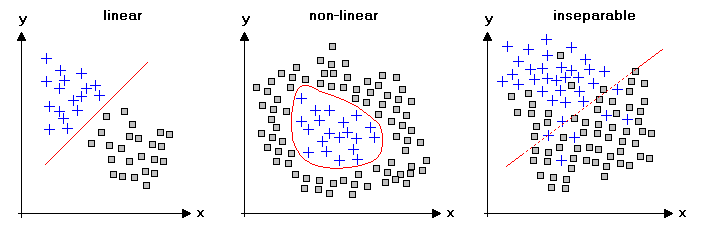

We will now visualize the decision boundary of our model by training the model on two important features: Mean Glasgow Coma scale and Mean heart rate.  

Do note that to being able to visualize the decision boundary in 2D, we have to reduce the model to a 2D problem by only using two features, this results in loss of information in higher dimensions.

In [ ]:
def visualize_boundaries(model,features,X,y,prob=True):
    already = []
    for x1 in features:
        already.append(x1)
        for x2 in features:
            if x2 not in already:
                X_visualize = X[[x1,x2]]
                
                model.fit(X_visualize[X_visualize.columns[0:2]], y.values.ravel())

                h = 0.01

                # create a mesh to plot in
                x_min, x_max = -0.02,1.02
                y_min, y_max = -0.02,1.02
                xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                     np.arange(y_min, y_max, h))



                if prob:
                    fig, axes = plt.subplots(1, 2,figsize=(14,6))
                else:
                    fig, axes = plt.subplots(1, 1,figsize=(7,6))
                
                Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

                # Put the result into a color plot
                Z = Z.reshape(xx.shape)
                
                if prob:
                    axes[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

                    # Plot also the training points
                    axes[0].scatter(X_visualize[X_visualize.columns[0:2][0]], X_visualize[X_visualize.columns[0:2][1]], c=y['mortality_icu'], cmap='bwr',alpha=0.3)
                    axes[0].set_xlabel(X_visualize.columns[0:2][0])
                    axes[0].set_ylabel(X_visualize.columns[0:2][1])
                    axes[0].set_xlim(xx.min(), xx.max())
                    axes[0].set_ylim(yy.min(), yy.max())
                    axes[0].set_title("Decision boundary")
    
    
                    #plt.xticks(())
                    #plt.yticks(())
                    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

                    # Put the result into a color plot
                    Z = Z.reshape(xx.shape)
                    pos = axes[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

                    # Plot also the training points
                    axes[1].scatter(X_visualize[X_visualize.columns[0:2][0]], X_visualize[X_visualize.columns[0:2][1]], c=y['mortality_icu'], cmap='bwr',alpha=0.3)
                    axes[1].set_xlabel(X_visualize.columns[0:2][0])
                    axes[1].set_ylabel(X_visualize.columns[0:2][1])
                    axes[1].set_xlim(xx.min(), xx.max())
                    axes[1].set_ylim(yy.min(), yy.max())
                    axes[1].set_title("Certainty of class")
                    #plt.xticks(())
                    #plt.yticks(())
                    #fig.colorbar(pos,ax=axes[1])
                    
                else:
                    axes.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

                    # Plot also the training points
                    axes.scatter(X_visualize[X_visualize.columns[0:2][0]], X_visualize[X_visualize.columns[0:2][1]], c=y['mortality_icu'], cmap='bwr',alpha=0.3)
                    axes.set_xlabel(X_visualize.columns[0:2][0])
                    axes.set_ylabel(X_visualize.columns[0:2][1])
                    axes.set_xlim(xx.min(), xx.max())
                    axes.set_ylim(yy.min(), yy.max())
                    axes.set_title("Decision boundary")
                    
                plt.show()

In [ ]:
visualize_boundaries(lr,["mean_heart_rate","mean_glasgow_coma_scale"],X_train_balanced,y_train_balanced)

>**Question: If you look closely, you can see that these features are not linearly seperable and the certainty for each class is also not very high. Do notice that the decision boundary is a straight line, why is that?**<br>

A: *Because the data is not linearly seperable, a straight line is the best solution.* <br>
B: *This is just by chance.* <br>
C: *Logistic regression is a linear model.* <br>
D: *None of the above* <br>

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

>**Question: If we added one extra feature, we visualise the data in a 3 dimensional space. What would the boundary of our model look like with 3 features? **<br>

A: *A (geometrical) plane* <br>
B: *A Möbius strip* <br>
C: *A line* <br>
D: *Two lines* <br>
E: *A sphere*<br>

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

In the next sections we will explore some non-linear models, in the hope to achieve better performance.

# K-nearest neighbours classification

Earlier the data was visualized and k-means clustering was used to both investigate properties of the data and do some preliminary classification. <br> 
K-nearest neighbours is a supervised classification algorithm that is similar to k-means clustering since it is fully distance based.
This type of classifier does not learn a model, but rather stores instances of training data and uses these to classify the testdata.

The algorithm works via the following pseudocode: <br>
1. For every $x_i$ in $\textbf{X}$ calculate $d(x_i, y)$
\begin{aligned}
d_i(x_i, y) = \left \| x_i-y \right \|^2,
\end{aligned}
2. Sort training labels according to distances
\begin{align}
y^s = Y[argsort([d_0, ..., d_N])]
\end{align}
3. Return majority label of K smallest distances
\begin{aligned}
\hat{y} = max\_count([y^s_0, ..., y^s_K])
\end{aligned}

For simplicity purposes we use the sklearn implementation of the K-nn classifier.

## Example in 2D

In order to illustrate how K-nn works we return to the two dimensional examples from the clustering section.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

K = 1

# fit model
knn = KNeighborsClassifier(n_neighbors=K, weights='uniform')
knn = knn.fit(X_train[s1], y_train) # Now we use data & labels

In [ ]:
print("TRAINING SET VISUALISATION")
visualize_boundaries(knn, s1, X_train, y_train, prob=False)
print("TEST SET VISUALISATION")
visualize_boundaries(knn, s1, X_test, y_test, prob=False)

Let's now train it on the complete dataset with all features and evaluate it on the test set: 

In [ ]:
# Number of neighbors
K = 5

# Fit classifier
knn = KNeighborsClassifier(n_neighbors=K, weights='uniform')
knn = knn.fit(X_train, y_train)

# Get results
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(knn, X_train, y_train, X_test, y_test)

all_results_train.loc['KNN'] = results_train.values[0]
all_results_test.loc['KNN'] = results_test.values[0]

> **Question: What is the influence of the number of neighbours hyperparameter ($K$) on the decision process?**

YOUR ANSWER HERE

> **Question: compare this visualization to the one presented in the clustering section. What difference in decision making do you observe and why?**

YOUR ANSWER HERE

In [ ]:
#This cell is intended to draw you attention to the previous' cell question.
dummy_var = False
assert dummy_var, "Do not forget to answer the previous two questions, once you have done that set dummy_var to True to continue"

# Decision Trees

Let's look at another model, the decision tree. These models use a tree structure to classify the patients into survivors or non-survivors based upon their features and characteristics, as seen in the theory lectures (chapter 10). Below you can see an example of such a classification decision tree

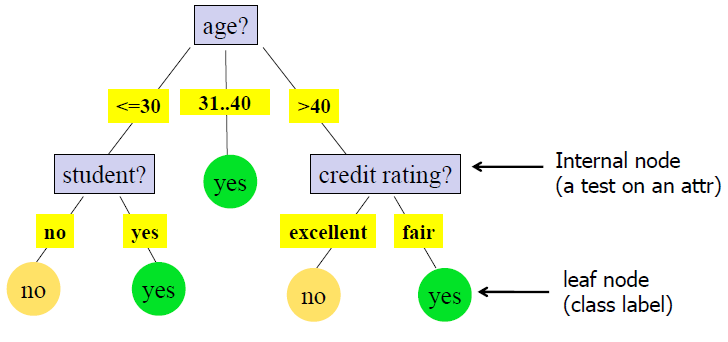

Similarly to the models above we will use the sklearn implementation and train a DecisionTreeClassifier model:

source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=10)

DTC.fit(X_train_balanced, y_train_balanced.values.ravel())

results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(DTC, X_train_balanced, y_train_balanced, X_test, y_test)

all_results_train.loc['DTC'] = results_train.values[0]
all_results_test.loc['DTC'] = results_test.values[0]

visualize_boundaries(DTC,["mean_heart_rate","mean_glasgow_coma_scale"],X_train_balanced,y_train_balanced)

Notice how the model has a perfect performance on the training data but a much worse performance on the test set. This is overfitting, where the model tries to achieve a perfect training performance by heavily optimizing itself. As a result the model cannot deal well with unseen data and achieves a bad performance on the test set.

If we visualize the decision boundaries on the training data you can clearly see that the model heavily overfitted. The model created a decision region for almost every sample, which results in poor generalisation values.

To avoid this we have to regularize the decision tree by for example limiting the maximum depth hyperparameter (see sklearn or theory) of the tree. However, we cannot simply select the optimal hyperparameter based upon  performance on the training set, and we cannot use the test set for optimizing either. As a result we have to create a new set from the training set to optimize this parameter, called the validation set. 

>**Question: Why can we not use the test set for optimizing hyperparameters?**<br>

A: *None of the answers below*<br>
B: *Using the test set to make decisions, e.g. to choose the better model or choose more appropriate features, will result in an inaccurate estimation of the performance on unseen data.*<br>
C: *You can only use the test set to tune hyperparameters for your final model, but not when developing a model, to make sure your model performs well on your use-case.*<br>
D: *Using the test set to make decisions, e.g. to choose the better model or choose more appropriate features, will result in an inaccurate estimation of the performance on seen data.*<br>

In [ ]:
Answer = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Answer != None

We will split the training dataset into a validation set and a training set using the sklearn train test split. A more optimal way would be to use cross-validation, however for the sake of this lab, we will stay with a single split.

In [ ]:
X_train_v, X_validation, y_train_v, y_validation = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

>**Exercise: Now we will optimize the *max_depth* hyperparameter of the decision tree. Use the new validation and training dataset to find the most optimal value. This hyperparameter limits the depth of the decision tree and is a way to regularize the model to avoid overfitting. Do not change the random_state.**

In [ ]:
DTC_Optimized = DecisionTreeClassifier(random_state=10,max_depth=None)
# YOUR CODE HERE
raise NotImplementedError()

results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(DTC_Optimized, X_train_v, y_train_v, X_validation, y_validation)

In [ ]:
#You can get a validation AUC result above 0.78
assert all_results_test.AUC[0]>0.78

Let's check the results of your model on the test set and visualize its boundaries by retraining it on the complete training set, because when evaluating your model on the test set for final performance evaluation you should always retrain your model on the **whole** training set, including the validation set. 

If you have correctly optimized your model, the performance on the test set should be approximately equal to that on the validation set above. Furthermore, we can see that the decision boundaries are less sparse, resulting in a model that has better generalization capabilities. 

In [ ]:
DTC_Optimized.fit(X_train_balanced, y_train_balanced.values.ravel())

results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(DTC_Optimized, X_train_balanced, y_train_balanced, X_test, y_test)

all_results_train.loc['DTC_optimized'] = results_train.values[0]
all_results_test.loc['DTC_optimized'] = results_test.values[0]
visualize_boundaries(DTC_Optimized,["mean_heart_rate","mean_glasgow_coma_scale"],X_train_balanced,y_train_balanced)

# Neural Networks

There are many more models that we could explore, however, we will shortly explore a fairly popular model: the neural network or multilayer perceptron and compare it to the other models. (if you are interested in other possible models visit https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) 

>**Excercise: Implement an MLP using the sklearn library and the MLPClassifier (source: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).**

If you want you can tune the hyperparameters on the validation data to create a model which has a higher AUC than the logistic regression model, however, this is not necessary but it will provide a better comparison for the next section.  

In [ ]:
from sklearn.neural_network import MLPClassifier

# YOUR CODE HERE
raise NotImplementedError()

results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(MLP, X_train_balanced, y_train_balanced, X_test, y_test)

all_results_train.loc['MLP'] = results_train.values[0]
all_results_test.loc['MLP'] = results_test.values[0]

At last, let's also visualize this decision boundary and certainty of an MLP model. 

In [ ]:
visualize_boundaries(MLP,["mean_heart_rate","mean_glasgow_coma_scale"],X_train_balanced,y_train_balanced)

# Comparison of classifiers

Now we have explored many different classifiers, let's check the performance on the training and the test set for all models and the difference between both. 

In [ ]:
print('Performance in training set')
display.display(np.round(all_results_train, decimals = 4))
print()

print('Performance in test set')
display.display(np.round(all_results_test, decimals = 4))
print()

diff = all_results_train-all_results_test
diff[['AUC', 'Sensitivity','Specificity']].plot(kind = 'bar', figsize = (10,3))
plt.ylabel('Difference in performance')
plt.xticks(rotation=None)
plt.title('Difference in performance (training - test)')
plt.show()

>**Question: Which model would you use to predict the mortality rate? Explain why AND how you would use this model in clinical practice.**

**Answer:**

YOUR ANSWER HERE

In [ ]:
#This cell is intended to draw you attention to the previous' cell question.
dummy_var = False
assert dummy_var, "Do not forget to answer the previous' cell question, once you have done that set dummy_var to True to continue"

**Question: Can you give an estimate of the time you spent on this part of the lab (number of hours)? You can also write down any other feedback you have about this lab, thanks!**

YOUR ANSWER HERE

In [ ]:
#This cell is intended to draw you attention to the previous' cell question.
dummy_var = False
assert dummy_var, "Do not forget to answer the previous' cell question it helps us improve the course material "